### Importing needed modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import tensorflow as tf
import os
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers, regularizers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, MaxPooling2D, Dense, Flatten, Activation

import keras_tuner as kt

### Loading the training and validation dataset using Keras

In [2]:
batch_size = 32
img_height = 120
img_width = 120

train_ds = tf.keras.utils.image_dataset_from_directory(
  r"C:\Users\franc\VSCode\FundAprendAuto\FAA-Project-1\images",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = True,
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  r"C:\Users\franc\VSCode\FundAprendAuto\FAA-Project-1\images",
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = True,
  )

train_ds = tf.keras.utils.image_dataset_from_directory(
  r"..\path\to\dataset",
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  shuffle = True,
  )

Found 6820 files belonging to 150 classes.
Using 5456 files for training.
Found 6820 files belonging to 150 classes.
Using 1364 files for validation.


In [3]:
class_names = train_ds.class_names
print("Existing classes")
print(class_names)

Existing classes
['Abra', 'Aerodactyl', 'Alakazam', 'Alolan Sandslash', 'Arbok', 'Arcanine', 'Articuno', 'Beedrill', 'Bellsprout', 'Blastoise', 'Bulbasaur', 'Butterfree', 'Caterpie', 'Chansey', 'Charizard', 'Charmander', 'Charmeleon', 'Clefable', 'Clefairy', 'Cloyster', 'Cubone', 'Dewgong', 'Diglett', 'Ditto', 'Dodrio', 'Doduo', 'Dragonair', 'Dragonite', 'Dratini', 'Drowzee', 'Dugtrio', 'Eevee', 'Ekans', 'Electabuzz', 'Electrode', 'Exeggcute', 'Exeggutor', 'Farfetchd', 'Fearow', 'Flareon', 'Gastly', 'Gengar', 'Geodude', 'Gloom', 'Golbat', 'Goldeen', 'Golduck', 'Golem', 'Graveler', 'Grimer', 'Growlithe', 'Gyarados', 'Haunter', 'Hitmonchan', 'Hitmonlee', 'Horsea', 'Hypno', 'Ivysaur', 'Jigglypuff', 'Jolteon', 'Jynx', 'Kabuto', 'Kabutops', 'Kadabra', 'Kakuna', 'Kangaskhan', 'Kingler', 'Koffing', 'Krabby', 'Lapras', 'Lickitung', 'Machamp', 'Machoke', 'Machop', 'Magikarp', 'Magmar', 'Magnemite', 'Magneton', 'Mankey', 'Marowak', 'Meowth', 'Metapod', 'Mew', 'Mewtwo', 'Moltres', 'MrMime', 'Muk'

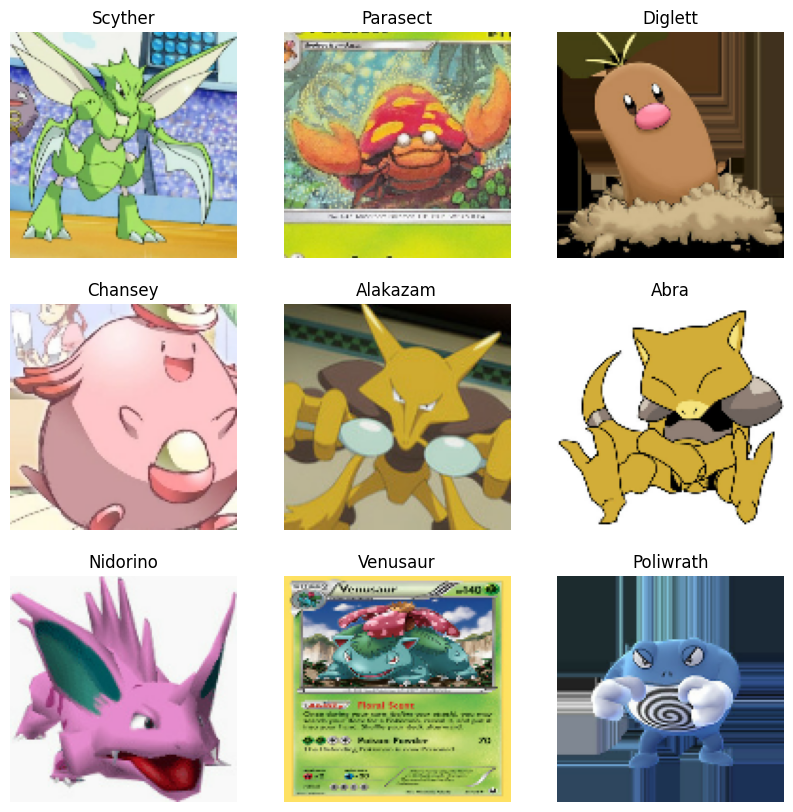

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 120, 120, 3)
(32,)


In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [140]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  Conv2D(16, 3, padding='same', activation='relu'),
  BatchNormalization(),

  MaxPooling2D(3,strides=(3,3)),

  Conv2D(32, 3, padding='same', activation='relu'),
  BatchNormalization(),

  MaxPooling2D(2,strides=(2,2)),

  Conv2D(64, 3, padding='same', activation='relu'),
  BatchNormalization(),

  Flatten(),
  Dense(128, activation='relu'),
  Dense(num_classes)
])

In [141]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [142]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_29 (Rescaling)    (None, 120, 120, 3)       0         
                                                                 
 conv2d_90 (Conv2D)          (None, 120, 120, 16)      448       
                                                                 
 batch_normalization_59 (Bat  (None, 120, 120, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 40, 40, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_91 (Conv2D)          (None, 40, 40, 32)        4640      
                                                                 
 batch_normalization_60 (Bat  (None, 40, 40, 32)     

In [143]:
epochs = 7

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=32,
    epochs=epochs,
)

Epoch 1/7
171/171 [==============================] - 21s 123ms/step - loss: 4.9567 - accuracy: 0.0332 - val_loss: 6.5295 - val_accuracy: 0.0220
Epoch 2/7
171/171 [==============================] - 21s 122ms/step - loss: 3.4598 - accuracy: 0.2133 - val_loss: 5.1253 - val_accuracy: 0.0806
Epoch 3/7
171/171 [==============================] - 20s 118ms/step - loss: 1.6495 - accuracy: 0.5724 - val_loss: 3.5333 - val_accuracy: 0.2559
Epoch 4/7
171/171 [==============================] - 20s 117ms/step - loss: 0.5144 - accuracy: 0.8633 - val_loss: 3.4331 - val_accuracy: 0.2793
Epoch 5/7
171/171 [==============================] - 20s 118ms/step - loss: 0.1370 - accuracy: 0.9688 - val_loss: 4.4005 - val_accuracy: 0.2691
Epoch 6/7
171/171 [==============================] - 20s 117ms/step - loss: 0.0613 - accuracy: 0.9943 - val_loss: 3.6004 - val_accuracy: 0.3460
Epoch 7/7
171/171 [==============================] - 20s 117ms/step - loss: 0.0193 - accuracy: 0.9984 - val_loss: 4.0295 - val_accuracy:

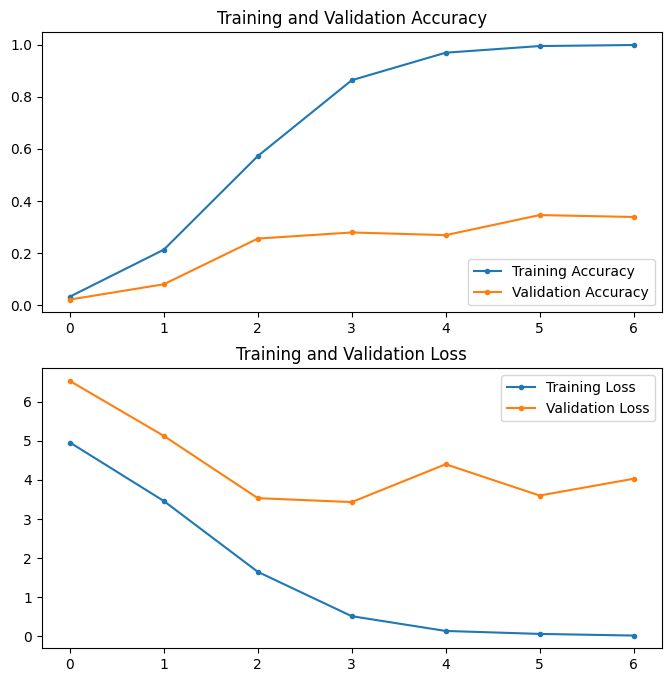

In [144]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker= '.')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker= '.')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker= '.')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker= '.')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [145]:
data_augmentation = Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

resize_and_rescale = Sequential([
  layers.Resizing(120,120),
  layers.Rescaling(1./255)
])


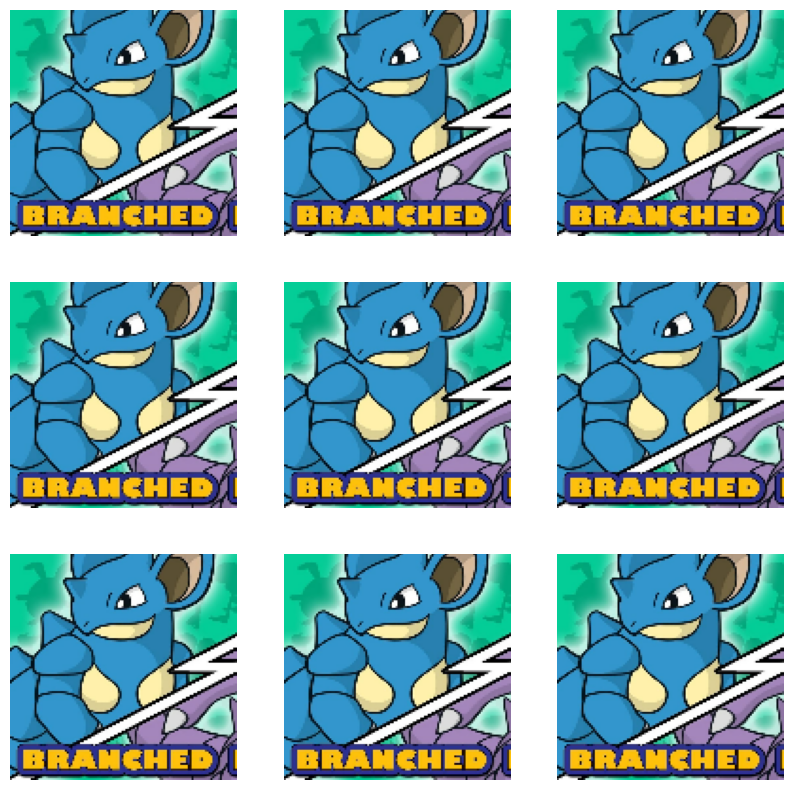

In [146]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [147]:
model1 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [148]:
model1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [149]:
model1.summary()

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_36 (Sequential)  (None, 120, 120, 3)       0         
                                                                 
 rescaling_31 (Rescaling)    (None, 120, 120, 3)       0         
                                                                 
 conv2d_93 (Conv2D)          (None, 120, 120, 16)      448       
                                                                 
 batch_normalization_62 (Bat  (None, 120, 120, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_75 (MaxPoolin  (None, 60, 60, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_94 (Conv2D)          (None, 60, 60, 32)      

In [150]:
epochs = 15
history1 = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
171/171 [==============================] - 30s 161ms/step - loss: 4.7270 - accuracy: 0.0345 - val_loss: 4.6731 - val_accuracy: 0.0447
Epoch 2/15
171/171 [==============================] - 27s 160ms/step - loss: 3.5864 - accuracy: 0.1455 - val_loss: 3.6013 - val_accuracy: 0.1738
Epoch 3/15
171/171 [==============================] - 27s 160ms/step - loss: 2.9590 - accuracy: 0.2656 - val_loss: 2.9830 - val_accuracy: 0.2573
Epoch 4/15
171/171 [==============================] - 27s 160ms/step - loss: 2.5710 - accuracy: 0.3402 - val_loss: 2.6934 - val_accuracy: 0.3233
Epoch 5/15
171/171 [==============================] - 27s 160ms/step - loss: 2.2354 - accuracy: 0.4194 - val_loss: 2.5527 - val_accuracy: 0.3680
Epoch 6/15
171/171 [==============================] - 27s 160ms/step - loss: 1.9679 - accuracy: 0.4811 - val_loss: 2.4912 - val_accuracy: 0.4040
Epoch 7/15
171/171 [==============================] - 27s 159ms/step - loss: 1.7538 - accuracy: 0.5181 - val_loss: 2.3113 - val_ac

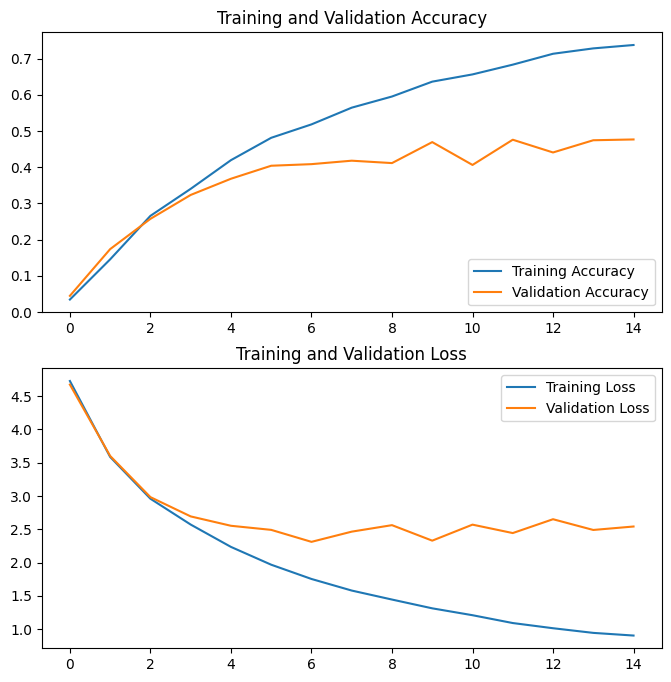

In [152]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [158]:
model2_l2 = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),

  Conv2D(16, 3, padding='same', activation='relu', kernel_regularizer='l2'),
  BatchNormalization(),
  MaxPooling2D(),

  Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer='l2'),
  MaxPooling2D(),

  Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer='l2'),
  MaxPooling2D(),

  Dropout(0.2),
  Flatten(),
  Dense(128, activation='relu', kernel_regularizer='l2'),
  Dense(num_classes)
])

In [159]:
model2_l2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [160]:
model2_l2.summary()

Model: "sequential_41"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_36 (Sequential)  (None, 120, 120, 3)       0         
                                                                 
 rescaling_34 (Rescaling)    (None, 120, 120, 3)       0         
                                                                 
 conv2d_102 (Conv2D)         (None, 120, 120, 16)      448       
                                                                 
 batch_normalization_67 (Bat  (None, 120, 120, 16)     64        
 chNormalization)                                                
                                                                 
 max_pooling2d_84 (MaxPoolin  (None, 60, 60, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_103 (Conv2D)         (None, 60, 60, 32)      

In [162]:
epochs = 15
history2 = model2_l2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
171/171 [==============================] - 30s 166ms/step - loss: 5.7969 - accuracy: 0.0224 - val_loss: 5.1314 - val_accuracy: 0.0411
Epoch 2/15
171/171 [==============================] - 28s 162ms/step - loss: 4.1171 - accuracy: 0.1245 - val_loss: 4.0300 - val_accuracy: 0.1767
Epoch 3/15
171/171 [==============================] - 28s 161ms/step - loss: 3.4985 - accuracy: 0.2154 - val_loss: 3.5840 - val_accuracy: 0.2229
Epoch 4/15
171/171 [==============================] - 28s 162ms/step - loss: 3.2201 - accuracy: 0.2698 - val_loss: 3.8340 - val_accuracy: 0.1833
Epoch 5/15
 19/171 [==>...........................] - ETA: 23s - loss: 3.0832 - accuracy: 0.3125

KeyboardInterrupt: 

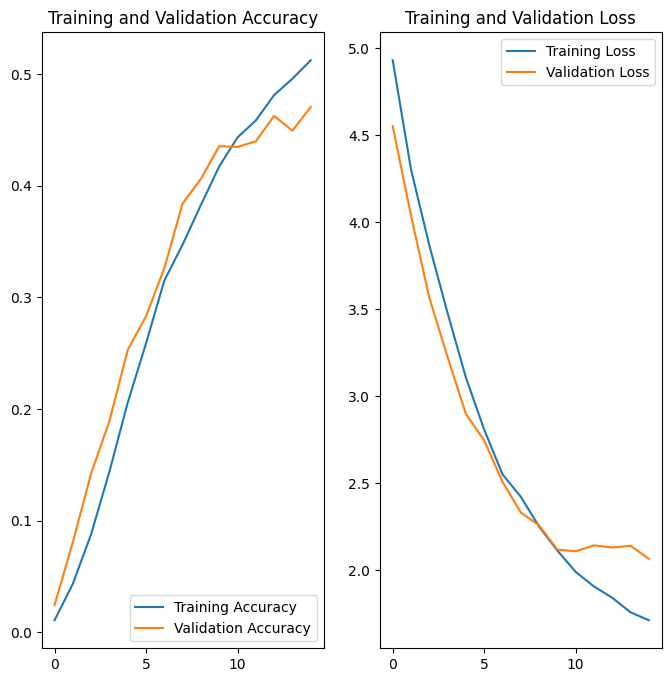

In [40]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()